## Data compilation

In [40]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import skew
from sklearn.preprocessing import normalize

plt.style.use('ggplot')
pd.options.display.max_columns=300 #increase columns shown 

## Combining dataset

We combine together training and test datasets, so that we can use the same variables and imputation methods across both dataset. We assign home price (SalePrice) values for test dataset at $99. This way we can separate datasets on next steps.

## Merging with time-series datasets

We are adding the following variables that may explain dynamics of housing prices:

* Dow Jones Real Estate index (lagged by one month)

* Fannie Mae mortgage rates (lagged)

* Labor force and Unemployment rate in Ames (lagged)

In [41]:
dataset = pd.read_csv('./data/dataset.csv')
school = pd.read_csv('./data/schoolsV2.csv')
school.drop(['Unnamed: 0', 'SalePrice','SalePrice2'], axis=1, inplace=True)

In [42]:
# A helper function that creates Month variable
def createMonth(date):
    '''
    A helper function that takes a date and returns an integer YYYYMM
    '''
    year = int(date.strftime('%Y'))
    month = int(date.strftime('%m'))
    
    return (year*100 +month)

# Dow Jones Real estate index
djre = pd.read_csv("./data/djre.csv", parse_dates=True)

djre['Date'] = pd.to_datetime(djre['Date']) #Convert to datetime

djre['Month'] = djre['Date'].apply(lambda x: createMonth(x))
djre = djre.groupby('Month').last().reset_index() # Keep end of month observation
djre.set_index('Date', inplace=True) # Set date index to use shift method later

djre = djre.shift(1) #Create a lagged variable

# fannie mae mortgage rates 
fannie = pd.read_csv('./data/FannieMaeRates.csv', parse_dates=True)

fannie['Date'] = pd.to_datetime(fannie['Date']) #Convert to datetime

fannie['Month'] = fannie['Date'].apply(lambda x: createMonth(x))
fannie = fannie.groupby('Month').last().reset_index() # Keep end of month observation
fannie.set_index('Date', inplace=True) # Set date index to use shift method later

fannie = fannie.shift(1) #Create a lagged variable
fannie.columns = ['Month', 'Fannie']


# Ames unemployment rate
unempl = pd.read_csv("./data/unempl.csv", parse_dates=True)

unempl['Month'] = unempl['Year']*100 + unempl['Month']
unempl['Date'] = pd.to_datetime(unempl['Month'], format='%Y%m') # Still need date to create lagged
unempl.drop(['Year', 'employment', 'unemployment'], axis=1, inplace=True)

unempl.set_index('Date', inplace=True) # Set date index to use shift method later

unempl = unempl.shift(1) #Create a lagged variable
unempl.columns = ['Month', 'LaborForce', 'UnemplRate']

# trailing 250 days corn prices
corn = pd.read_csv('./data/corn.csv')
corn['date'] = pd.to_datetime(corn['date']) #Convert to datetime
corn.set_index('date', inplace=True)
corn['corn'] = corn['corn'].rolling(window = 250, min_periods=250).mean() #Calculaet rolling mean price
corn = corn.loc['2000-01-01':,].reset_index()

corn['Month'] = corn['date'].apply(lambda x: createMonth(x))
corn = corn.groupby('Month').last().reset_index() # Keep end of month observation
corn.set_index('date', inplace=True) # Set date index to use shift method later

corn = corn.shift(1) #Create a lagged variable
corn.columns = ['Month', 'Corn']


# Combine with the dataset
dataset = pd.merge(dataset, djre, on='Month', how='left')
dataset = pd.merge(dataset, fannie, on='Month', how='left')
dataset = pd.merge(dataset, unempl, on='Month', how='left')
dataset = pd.merge(dataset, corn, on='Month', how='left')





In [43]:
print (dataset.shape)
dataset.head()

(2919, 87)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Month,DJREI,Fannie,LaborForce,UnemplRate,Corn
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,99,201006,183.00,4.561,51950.0,4.7,3.610178
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,99,201006,183.00,4.561,51950.0,4.7,3.610178
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,99,201003,193.37,4.762,53639.0,4.6,3.734616
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,99,201006,183.00,4.561,51950.0,4.7,3.610178
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,99,201001,168.83,4.993,52631.0,4.8,3.746940


In [44]:
print (school.shape)
school.head()

(2919, 9)


,Id,EdwardsSchool,FellowsSchool,MeekerSchool,MitchellSchool,SawyerSchool,NorthwoodSchool,MiddleSchool,HighSchool
0,1461,6.851780,1.325674,1.400679,7.135226,5.198126,0.320684,6.129312,1.941903
1,1462,6.852189,1.308569,1.353525,7.090138,5.210126,0.274501,6.122509,1.933945
2,1463,6.346410,2.202827,3.003807,8.445171,4.354091,2.056549,5.915529,2.328002
3,1464,6.336219,2.190399,2.993610,8.432552,4.345406,2.048375,5.903955,2.314690
4,1465,6.596845,2.047714,2.718186,8.279412,4.657568,1.714825,6.102558,2.296615


In [45]:
dataset = pd.merge(dataset, school, on='Id', how='left')

In [46]:
print (dataset.shape)
dataset.head()

(2919, 95)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Month,DJREI,Fannie,LaborForce,UnemplRate,Corn,EdwardsSchool,FellowsSchool,MeekerSchool,MitchellSchool,SawyerSchool,NorthwoodSchool,MiddleSchool,HighSchool
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,99,201006,183.00,4.561,51950.0,4.7,3.610178,6.851780,1.325674,1.400679,7.135226,5.198126,0.320684,6.129312,1.941903
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,99,201006,183.00,4.561,51950.0,4.7,3.610178,6.852189,1.308569,1.353525,7.090138,5.210126,0.274501,6.122509,1.933945
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,99,201003,193.37,4.762,53639.0,4.6,3.734616,6.346410,2.202827,3.003807,8.445171,4.354091,2.056549,5.915529,2.328002
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,99,201006,183.00,4.561,51950.0,4.7,3.610178,6.336219,2.190399,2.993610,8.432552,4.345406,2.048375,5.903955,2.314690
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,99,201001,168.83,4.993,52631.0,4.8,3.746940,6.596845,2.047714,2.718186,8.279412,4.657568,1.714825,6.102558,2.296615


## Imputation of missingness

First, we analyze the missing values in our dataset and impute them.

In [47]:
#missing data
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data[missing_data['Total'].values> 0]

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageQual,159,0.054471
GarageCond,159,0.054471
GarageFinish,159,0.054471
GarageYrBlt,159,0.054471


In [48]:
#a look at rows with missing data
null_data = dataset[dataset.isnull().any(axis=1)]
null_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Month,DJREI,Fannie,LaborForce,UnemplRate,Corn,EdwardsSchool,FellowsSchool,MeekerSchool,MitchellSchool,SawyerSchool,NorthwoodSchool,MiddleSchool,HighSchool
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,99,201006,183.00,4.561,51950.0,4.7,3.610178,6.851780,1.325674,1.400679,7.135226,5.198126,0.320684,6.129312,1.941903
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,99,201006,183.00,4.561,51950.0,4.7,3.610178,6.852189,1.308569,1.353525,7.090138,5.210126,0.274501,6.122509,1.933945
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,99,201003,193.37,4.762,53639.0,4.6,3.734616,6.346410,2.202827,3.003807,8.445171,4.354091,2.056549,5.915529,2.328002
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,99,201006,183.00,4.561,51950.0,4.7,3.610178,6.336219,2.190399,2.993610,8.432552,4.345406,2.048375,5.903955,2.314690
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,99,201001,168.83,4.993,52631.0,4.8,3.746940,6.596845,2.047714,2.718186,8.279412,4.657568,1.714825,6.102558,2.296615


We handle missing values based on our understanding of why the vallue is missing.

For example, missing value for AlleyAccess seems to mean that there is no alley access to the property. Therefore, we impute missing values with 'None'.

In [49]:
# Alley : data description says NA means "no alley access"
dataset.loc[:, "Alley"] = dataset.loc[:, "Alley"].fillna("None")

The missing value for the basement feature are probably explained by the absense of a basement.

In [50]:
# BsmtQual etc : data description says NA for basement features is "no basement"
dataset.loc[:, "BsmtQual"] = dataset.loc[:, "BsmtQual"].fillna("No")
dataset.loc[:, "BsmtCond"] = dataset.loc[:, "BsmtCond"].fillna("No")
dataset.loc[:, "BsmtExposure"] = dataset.loc[:, "BsmtExposure"].fillna("No")
dataset.loc[:, "BsmtFinType1"] = dataset.loc[:, "BsmtFinType1"].fillna("No")
dataset.loc[:, "BsmtFinType2"] = dataset.loc[:, "BsmtFinType2"].fillna("No")
dataset.loc[:, "BsmtFullBath"] = dataset.loc[:, "BsmtFullBath"].fillna(0)
dataset.loc[:, "BsmtHalfBath"] = dataset.loc[:, "BsmtHalfBath"].fillna(0)
dataset.loc[:, "BsmtUnfSF"] = dataset.loc[:, "BsmtUnfSF"].fillna(0)

We handle other missing features in the similar manner.

In [51]:

# Fence : data description says NA means "no fence"
dataset.loc[:, "Fence"] = dataset.loc[:, "Fence"].fillna("No")

# FireplaceQu : data description says NA means "no fireplace"
dataset.loc[:, "FireplaceQu"] = dataset.loc[:, "FireplaceQu"].fillna("No")

# Functional : data description says NA means typical
dataset.loc[:, "Functional"] = dataset.loc[:, "Functional"].fillna("Typ")

# GarageType etc : data description says NA for garage features is "no garage"
dataset.loc[:, "GarageType"] = dataset.loc[:, "GarageType"].fillna("No")
dataset.loc[:, "GarageFinish"] = dataset.loc[:, "GarageFinish"].fillna("No")
dataset.loc[:, "GarageQual"] = dataset.loc[:, "GarageQual"].fillna("No")
dataset.loc[:, "GarageCond"] = dataset.loc[:, "GarageCond"].fillna("No")
dataset.loc[:, "GarageArea"] = dataset.loc[:, "GarageArea"].fillna(0)
dataset.loc[:, "GarageCars"] = dataset.loc[:, "GarageCars"].fillna(0)
dataset.loc[:, "GarageYrBlt"] = dataset.loc[:, "GarageYrBlt"].fillna(0)

# KitchenQual : NA most likely means typical
dataset.loc[:, "KitchenQual"] = dataset.loc[:, "KitchenQual"].fillna("TA")

# MasVnrType : NA most likely means no veneer
dataset.loc[:, "MasVnrType"] = dataset.loc[:, "MasVnrType"].fillna("None")
dataset.loc[:, "MasVnrArea"] = dataset.loc[:, "MasVnrArea"].fillna(0)

# MiscFeature : data description says NA means "no misc feature"
dataset.loc[:, "MiscFeature"] = dataset.loc[:, "MiscFeature"].fillna("No")

# PoolQC : data description says NA means "no pool"
dataset.loc[:, "PoolQC"] = dataset.loc[:, "PoolQC"].fillna("No")

# Utilities : NA most likely means all public utilities
dataset.loc[:, "Utilities"] = dataset.loc[:, "Utilities"].fillna("AllPub")

#median
dataset["LotFrontage"] = dataset.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

#mode, categorical
dataset["MSZoning"] = dataset.groupby("Neighborhood")["MSZoning"].transform(lambda x: x.fillna(x.mode()[0]))
dataset["SaleType"] = dataset.groupby("Neighborhood")["SaleType"].transform(lambda x: x.fillna(x.mode()[0]))
dataset["Electrical"] = dataset.groupby("Neighborhood")["Electrical"].transform(lambda x: x.fillna(x.mode()[0]))
dataset["Exterior1st"] = dataset.groupby("Neighborhood")["Exterior1st"].transform(lambda x: x.fillna(x.mode()[0]))
dataset["Exterior2nd"] = dataset.groupby("Neighborhood")["Exterior2nd"].transform(lambda x: x.fillna(x.mode()[0]))

#looking at the NA row, basement is nonexistent so basement SF is 0 
dataset.loc[:, "TotalBsmtSF"] = dataset.loc[:, "TotalBsmtSF"].fillna(0)
dataset.loc[:, "BsmtFinSF1"] = dataset.loc[:, "BsmtFinSF1"].fillna(0)
dataset.loc[:, "BsmtFinSF2"] = dataset.loc[:, "BsmtFinSF2"].fillna(0)


Check that there are no more missing values

In [52]:
#let's take a look at the data now
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data[missing_data['Total'].values> 0]

,Total,Percent
HighSchool,11,0.003768
NorthwoodSchool,11,0.003768
SawyerSchool,11,0.003768
MitchellSchool,11,0.003768
MeekerSchool,11,0.003768
FellowsSchool,11,0.003768
EdwardsSchool,11,0.003768
MiddleSchool,11,0.003768


### fill in data for schools

In [53]:
dataset["HighSchool"] = dataset.groupby("Neighborhood")["HighSchool"].transform(lambda x: x.fillna(x.mean()))
dataset["MiddleSchool"] = dataset.groupby("Neighborhood")["MiddleSchool"].transform(lambda x: x.fillna(x.mean()))
dataset["NorthwoodSchool"] = dataset.groupby("Neighborhood")["NorthwoodSchool"].transform(lambda x: x.fillna(x.mean()))
dataset["SawyerSchool"] = dataset.groupby("Neighborhood")["SawyerSchool"].transform(lambda x: x.fillna(x.mean()))
dataset["MitchellSchool"] = dataset.groupby("Neighborhood")["MitchellSchool"].transform(lambda x: x.fillna(x.mean()))
dataset["MeekerSchool"] = dataset.groupby("Neighborhood")["MeekerSchool"].transform(lambda x: x.fillna(x.mean()))
dataset["FellowsSchool"] = dataset.groupby("Neighborhood")["FellowsSchool"].transform(lambda x: x.fillna(x.mean()))
dataset["EdwardsSchool"] = dataset.groupby("Neighborhood")["EdwardsSchool"].transform(lambda x: x.fillna(x.mean()))

In [54]:
#let's take a look at the data now
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data[missing_data['Total'].values> 0]

,Total,Percent


In [55]:
dataset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Month,DJREI,Fannie,LaborForce,UnemplRate,Corn,EdwardsSchool,FellowsSchool,MeekerSchool,MitchellSchool,SawyerSchool,NorthwoodSchool,MiddleSchool,HighSchool
0,1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,No,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,No,MnPrv,No,0,6,2010,WD,Normal,99,201006,183.00,4.561,51950.0,4.7,3.610178,6.851780,1.325674,1.400679,7.135226,5.198126,0.320684,6.129312,1.941903
1,1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,No,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,No,No,Gar2,12500,6,2010,WD,Normal,99,201006,183.00,4.561,51950.0,4.7,3.610178,6.852189,1.308569,1.353525,7.090138,5.210126,0.274501,6.122509,1.933945
2,1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,No,MnPrv,No,0,3,2010,WD,Normal,99,201003,193.37,4.762,53639.0,4.6,3.734616,6.346410,2.202827,3.003807,8.445171,4.354091,2.056549,5.915529,2.328002
3,1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,No,No,No,0,6,2010,WD,Normal,99,201006,183.00,4.561,51950.0,4.7,3.610178,6.336219,2.190399,2.993610,8.432552,4.345406,2.048375,5.903955,2.314690
4,1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,No,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,No,No,No,0,1,2010,WD,Normal,99,201001,168.83,4.993,52631.0,4.8,3.746940,6.596845,2.047714,2.718186,8.279412,4.657568,1.714825,6.102558,2.296615


## Create one hot representation

In [56]:
# Find categorical variables
df = dataset.copy()


numerical = list(set(df.mean().index) - set(['MSSubClass']))
categorical = list(set(df.columns) - set(numerical))

# Convert into categorical
for column in categorical:
    df[column] = df[column].astype('category')


df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Month,DJREI,Fannie,LaborForce,UnemplRate,Corn,EdwardsSchool,FellowsSchool,MeekerSchool,MitchellSchool,SawyerSchool,NorthwoodSchool,MiddleSchool,HighSchool
0,1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,No,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,No,MnPrv,No,0,6,2010,WD,Normal,99,201006,183.00,4.561,51950.0,4.7,3.610178,6.851780,1.325674,1.400679,7.135226,5.198126,0.320684,6.129312,1.941903
1,1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,No,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,No,No,Gar2,12500,6,2010,WD,Normal,99,201006,183.00,4.561,51950.0,4.7,3.610178,6.852189,1.308569,1.353525,7.090138,5.210126,0.274501,6.122509,1.933945
2,1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,No,MnPrv,No,0,3,2010,WD,Normal,99,201003,193.37,4.762,53639.0,4.6,3.734616,6.346410,2.202827,3.003807,8.445171,4.354091,2.056549,5.915529,2.328002
3,1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,No,No,No,0,6,2010,WD,Normal,99,201006,183.00,4.561,51950.0,4.7,3.610178,6.336219,2.190399,2.993610,8.432552,4.345406,2.048375,5.903955,2.314690
4,1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,No,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,No,No,No,0,1,2010,WD,Normal,99,201001,168.83,4.993,52631.0,4.8,3.746940,6.596845,2.047714,2.718186,8.279412,4.657568,1.714825,6.102558,2.296615


Pickle list of types

In [58]:
# Exclude Sales price from numerical list
numerical = list(set(numerical) - set(['SalePrice', 'Id']))

pickle.dump(numerical, open('./tmp/numerical.list', 'wb'))
pickle.dump(categorical, open('./tmp/categorical.list', 'wb'))


Create one hot vector of numerical

In [59]:
# Create dummies
one_hot_data = pd.get_dummies(df[categorical],drop_first=True)

#Drop categorical
df = df.drop(categorical, axis=1)

# Merge with one hot
df = df.join(one_hot_data)
df.shape

(2919, 288)

## SalePrice vs. Log Sale Price

For our models we choose whether to use the sales prices or the log of them. Let's look at the distribution of the prices in our dataset.

       price  log(price)
1459  208500   12.247694
1460  181500   12.109011
1461  223500   12.317167
1462  140000   11.849398
1463  250000   12.429216


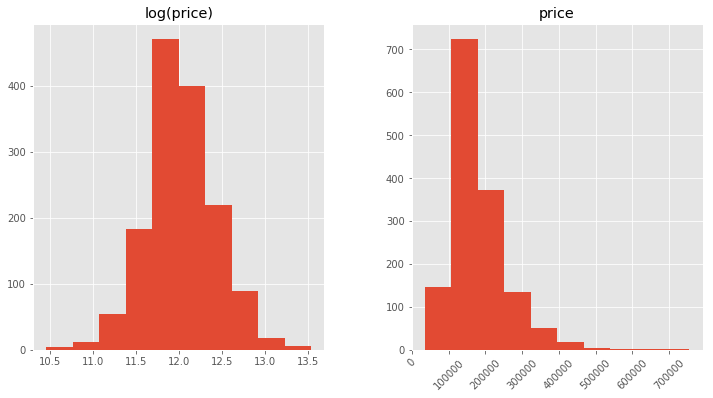

In [61]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
saleprices = df.loc[df['SalePrice']!=99,'SalePrice']
prices = pd.DataFrame({"price":saleprices, "log(price)":np.log(saleprices)})
print (prices.head())
prices.hist()
plt.xticks(rotation=45)
plt.savefig('./output/price_vs_log.png', dpi=300)

It seems that the prices follow the lognormal distribution. Therefore, we will use log of prices as our response variable.

To illustrate it we plot scatter plots of Sales Price and Living Area

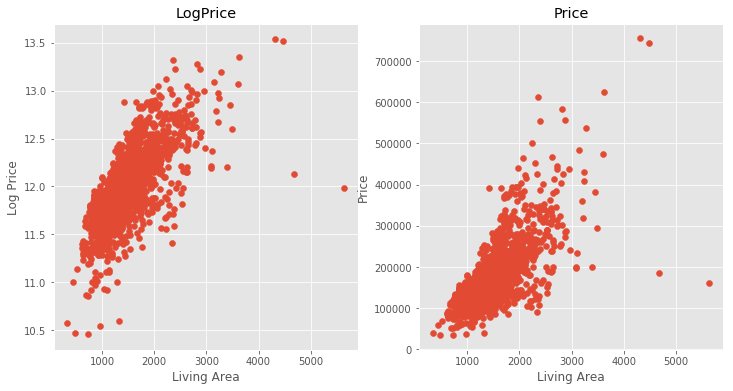

In [62]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":saleprices, "log(price)":np.log(saleprices)})
prices = prices.join(pd.DataFrame({'LivingArea':df.GrLivArea}))

plt.subplot(1,2,1)
plt.scatter(prices['LivingArea'], prices['log(price)'])
plt.ylabel('Log Price')
plt.xlabel('Living Area')
plt.title('LogPrice')

plt.subplot(1,2,2)
plt.scatter(prices['LivingArea'], prices['price'])
plt.ylabel('Price')
plt.xlabel('Living Area')
plt.title('Price')

plt.savefig('./output/price_vs_log_vs_living.png', dpi=300)

In [63]:
def correctWrong(series, threshold=5):
    '''
    A helper function that returns series with variables that deviate from the mean by more than a threshold
    imputed by the mean
    '''
    series_nonnull = series[series!=0]
    mean = np.mean(series_nonnull)
    std = np.std(series_nonnull)
    
    series[series!=0] = series[series!=0].map(lambda x: x if x< (mean + threshold*std) else mean)
    
    return series
    
df[numerical] = df[numerical].apply(correctWrong)

C:\Users\asus\Anaconda2\envs\ipykernel_py3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\asus\Anaconda2\envs\ipykernel_py3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\asus\Anaconda2\envs\ipykernel_py3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

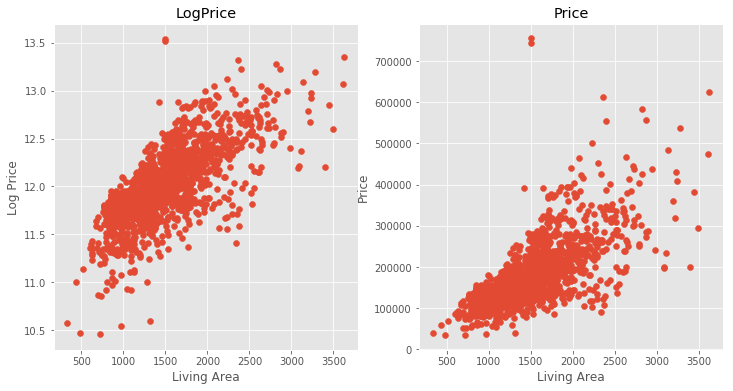

In [64]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":saleprices, "log(price)":np.log(saleprices)})
prices = prices.join(pd.DataFrame({'LivingArea':df.GrLivArea}))

plt.subplot(1,2,1)
plt.scatter(prices['LivingArea'], prices['log(price)'])
plt.ylabel('Log Price')
plt.xlabel('Living Area')
plt.title('LogPrice')

plt.subplot(1,2,2)
plt.scatter(prices['LivingArea'], prices['price'])
plt.ylabel('Price')
plt.xlabel('Living Area')
plt.title('Price')

plt.savefig('./output/price_vs_log_vs_living_nooutliers.png', dpi=300)

## Feature Engeneering

Next, we look at distributions of numerical features and their skeweness.

In [65]:
skewed_feats = df[numerical].apply(lambda x: skew(x)) # compute skewness

# Select where skewenes is >0.75
skewed_feats = skewed_feats[skewed_feats>0.75]

# Get names of skewed features
sk_feat = list(skewed_feats.index.values)
skewed_feats

3SsnPorch        11.376065
ScreenPorch       3.798727
WoodDeckSF        1.443151
BsmtFinSF1        0.850062
BsmtHalfBath      3.707339
MasVnrArea        2.405346
BsmtFinSF2        4.146143
MiscVal          20.035401
LotArea           2.287168
OpenPorchSF       1.888842
EnclosedPorch     3.137623
LaborForce        1.227812
PoolArea         16.898328
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
KitchenAbvGr      4.150125
GrLivArea         0.874911
HighSchool        0.774630
LowQualFinSF     12.088761
1stFlrSF          0.822144
dtype: float64

We perform log transformation of the skewed variables

In [66]:
# Save initial values for comparison
init_skewed = df[sk_feat]

# Apply Log+1 transformation
df[sk_feat] = np.log1p(df[sk_feat])

Plot new features histograms

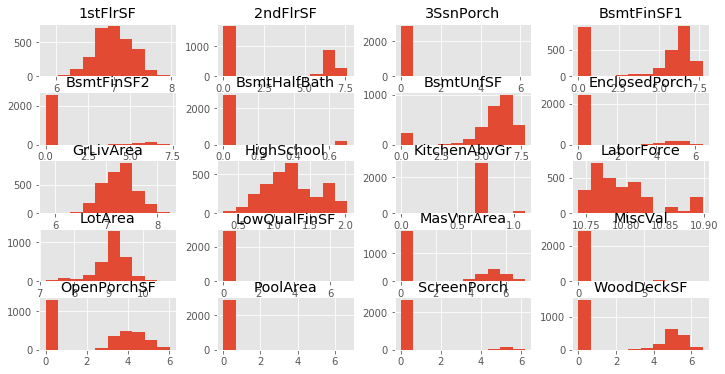

In [67]:
# Calculate skewenes
_ = df[sk_feat].hist()
plt.savefig('./output/skewed_hist.png', dpi=300)

For illistration, we plot the same scatter plots but using transformed living space variable.

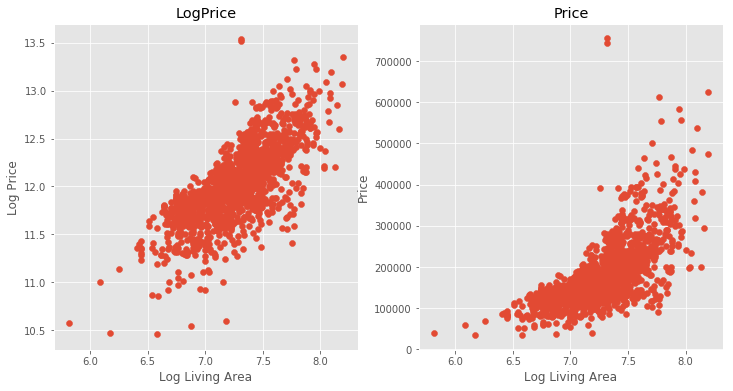

In [68]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":saleprices, "log(price)":np.log(saleprices)})
prices = prices.join(pd.DataFrame({'LivingArea':df.GrLivArea}))

plt.subplot(1,2,1)
plt.scatter(prices['LivingArea'], prices['log(price)'])
plt.ylabel('Log Price')
plt.xlabel('Log Living Area')
plt.title('LogPrice')

plt.subplot(1,2,2)
plt.scatter(prices['LivingArea'], prices['price'])
plt.ylabel('Price')
plt.xlabel('Log Living Area')
plt.title('Price')

plt.savefig('./output/price_vs_log_vs_logliving.png', dpi=300)

In [69]:
# Save skewed features list
pickle.dump(sk_feat, open('./tmp/sk_feat.list', 'wb'))

## Divide into train and test sets

We divide the merged dataset into new train and test datasets, using SalePrice == 99 as a criterion. 

In [71]:
new_train = df.loc[df['SalePrice']!=99,:]
new_test = df.loc[df['SalePrice']==99,:].copy()
new_test.drop('SalePrice', axis=1, inplace=True)



print(new_train.shape)
print(new_test.shape)

#assert(test.shape[0]==new_test.shape[0])

(1460, 288)
(1459, 287)


In [72]:
new_train.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,Month,DJREI,Fannie,LaborForce,UnemplRate,Corn,EdwardsSchool,FellowsSchool,MeekerSchool,MitchellSchool,SawyerSchool,NorthwoodSchool,MiddleSchool,HighSchool,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_No,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,PavedDrive_P,PavedDrive_Y,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_No,BsmtFinType2_Rec,BsmtFinType2_Unf,Alley_None,Alley_Pave,GarageCond_Fa,GarageCond_Gd,GarageCond_No,GarageCond_Po,GarageCond_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,GarageQual_Fa,GarageQual_Gd,GarageQual_No,GarageQual_Po,GarageQual_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,CentralAir_Y,Street_Pave,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_No,BsmtFinType1_Rec,BsmtFinType1_Unf,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf,LandSlope_Mod,LandSlope_Sev,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Utilities_NoSeWa,MiscFeature_No,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,PoolQC_Fa,PoolQC_Gd,PoolQC_No,LandContour_HLS,LandContour_Low,LandContour_Lvl,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No,FireplaceQu_Po,FireplaceQu_TA,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No,BsmtQual_TA,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,BsmtCond_Gd,BsmtCond_No,BsmtCond_Po,BsmtCond_TA,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborho

In [73]:
# Save new test and train sets
new_test.to_csv('./data/new_test_school.csv')
new_train.to_csv('./data/new_train_school.csv')